<a href="https://colab.research.google.com/github/mathewchamberlain/MBA/blob/main/HW_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alternative HW assignment




## Setup

Lets start by importing the packages we'll need and mounting our Google Drive as before. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from google.colab import drive
from sklearn.preprocessing import PolynomialFeatures
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# import the data
df = pd.read_csv('/content/drive/MyDrive/housing22.csv', delimiter=',',index_col = 0)

In [4]:
# remove all instances where population is less than 2000 or total_rooms < 35000
df = df[(df['population'] < 20000) | (df['total_rooms'] < 35000)]
# replace missing values with the column median
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

In [5]:
# split test and train using the first 5000 rows. Setup test + train.
n = df.shape[0] - 5000
df_train = df.head(5000)
df_test = df.tail(n)
y_train = df_train['median_house_value']
y_test = df_test['median_house_value']
df_train = df_train.drop('median_house_value', axis=1)
df_test = df_test.drop('median_house_value', axis=1)
print(df_train.shape, df_test.shape)

(5000, 11) (3002, 11)


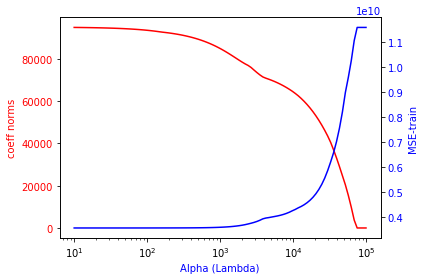

In [6]:
# make 100 values of lambda
lambda_vals = np.logspace(1,5,100)
norms = []
mses = []
mses_test = []
coefs = []

# generate LASSO model with standardization
for a in lambda_vals: 
  model = make_pipeline(StandardScaler(with_mean=False),
                      Lasso(alpha=a, max_iter=10000))
  model.fit(df_train, y_train)
  norms.append(np.linalg.norm(model['lasso'].coef_)) # store model coef
  mses.append(mean_squared_error(model.predict(df_train),y_train)) # store MSE
  mses_test.append(mean_squared_error(model.predict(df_test),y_test)) # store MSE
  coefs.append(model['lasso'].coef_)  # sparse matrix)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Alpha (Lambda)', color='b')
ax1.set_ylabel('coeff norms', color='r')
ax1.set_xscale('log')
ax1.plot(lambda_vals, np.array(norms), color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis

ax2.set_ylabel('MSE-train', color='b')  #  already handled the x-label 
ax2.plot(lambda_vals, np.array(mses), color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout() 
plt.show()

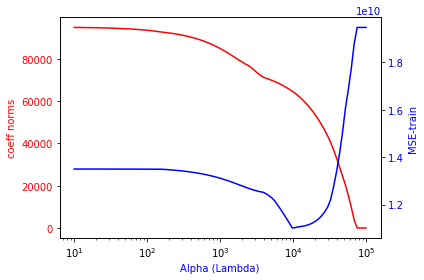

In [7]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Alpha (Lambda)', color='b')
ax1.set_ylabel('coeff norms', color='r')
ax1.set_xscale('log')
ax1.plot(lambda_vals, np.array(norms), color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis

ax2.set_ylabel('MSE-train', color='b')  #  already handled the x-label 
ax2.plot(lambda_vals, np.array(mses_test), color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout() 
plt.show()

*We* can refresh our memories of what goes on in the dataset by looking at the column names. 

In [23]:
dc = pd.DataFrame(coefs, columns = df_train.columns)
dc['lambda'] = lambda_vals

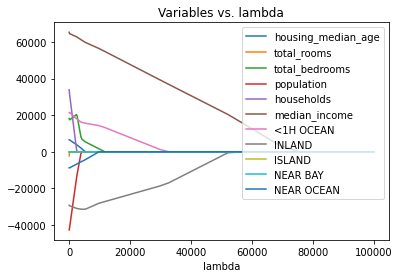

In [44]:
import matplotlib.pyplot as plt
company_list = dc.columns.drop('lambda')
dc.plot(x='lambda', y = company_list, title=f'Variables vs. lambda')
plt.show()

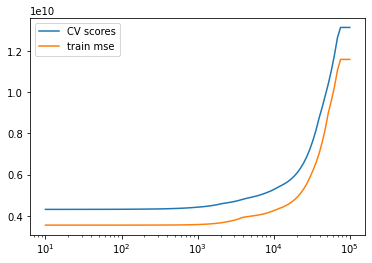

In [45]:
from sklearn.model_selection import cross_val_score
cvs = []
train_mses=[]

for a in lambda_vals: 
  model = make_pipeline(StandardScaler(with_mean=False),
                      Lasso(alpha=a, max_iter=10000))
  cv_a = cross_val_score(model, df_train, y_train, cv=5, scoring='neg_mean_squared_error')
  cvs.append(np.mean(-cv_a))

  #for comparison
  model.fit(df_train, y_train)
  train_mses.append(mean_squared_error(model.predict(df_train),y_train))

plt.xscale('log')
plt.plot(lambda_vals, cvs, label='CV scores')
plt.plot(lambda_vals, train_mses, label='train mse')
plt.legend()

## Training a linear regression model

Let's start by setting up a very simple model that only cares about which browser a user uses. We will create a list, `predictors1` to hold ne column names of the predictors we want to include in our model to make indexing easier.

In [ ]:
predictors = ['browser1', 'browser2', 'browser3']
X1_train = df_train[predictors]
X1_test = df_test[predictors]
y_train = df_train['p_open']
y_test = df_test['p_open']

Now we can follow the same four steps as always. First, choose a model class, instantiante the model and set hyperparameter values, then fit to your data. Remember we can access model attributes, in this case the coefficients and intercepts term.  

In [ ]:
from sklearn.linear_model import LinearRegression # 1. choose model class

model = # your code here                          # 2. instantiate model
# your code here                                  # 3. fit model to data

model.coef_, model.intercept_

Finally, we make predictions on the training and test set and evaluate the mean squared error. Of course, there are automated functions for this, but let's do it manually so that we can make sure we understand how it works. 

First we predict on the training data:

In [ ]:
y_train_fit = # your code here                  # 4a. predict on training data

from sklearn.metrics import mean_squared_error
# your code here                                # Evaluate

Then on the testing data:

In [ ]:
y_test_fit =  # your code here                  # 4b. predict on test data
# your code here                                # Evaluate

In this case our MSE is pretty similar, so it's unlikely we overfit. Is this a "good" MSE? We don't really know, but we can say that our open-rate predictions are, on average, off by about 17\%. 


## Regularised regression models



### Ridge regression

Recall that ridge regression minimizes $\sum_i (y_i - \hat{y}_i) + \lambda \sum_{j=1}^p \beta_j^2, $ where $\lambda$ is the regularization paramter and $\beta$ the coefficients of the model. 
In the `Ridge` model, the regularisation parameter is called `alpha`.

Since we are penalising the coefficients, it is important that all the predictors are on the same scale. Here, we'll use the `StandardScalar` transform to ensure every predictor has mean  0 and standard deviation 1. Make sure you look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

Note that there is a difference between standardisation and normalisation, which simply ensures all values fall between 0 and 1. 

In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
X1_std_train = scaler.fit_transform(X1_train)
X1_std_test = scaler.fit_transform(X1_test)

#notice we now have stdev 1 and mean 0 
X1_std_train[:,:].std(axis=0), X1_std_train[:,:].mean(axis=0)

Now we can instantiate and fit the model. Here, we will do 10-fold cross validation and pass an array of regularization parameters to try. After fitting `Ridge.coeff_` contains the coefficients. 

In [ ]:
from sklearn.linear_model import Ridge

ridge = # your code here    # instantiate
# your code here            # fit to training data

ridge.coef_

We can compute the MSE manually as before. Let's just do the test MSE this time. 

In [ ]:
# your code here 

### Fitting Lasso and ElasticNet
Recall that lasso minimizes $\sum_i (y_i - \hat{y}_i) + \lambda \sum_{j=1}^p |\beta_j|, $ where $\lambda$ is the regularization paramter and $\beta$ the coefficients of the model.
The `Lasso` interface is very similar to `Ridge`. Instantiate the model, fit it to your training data, make predictions and evaluate the test MSE.  


In [ ]:
# import Lasso from sklearn.linear_model

# instantiate the Lasso model

# fit to X1_std_train

# predict on the test set

# evaluate MSE on the test set

Elastic nets minimize $\sum_i (y_i - \hat{y}_i) + \lambda \sum_{j=1}^p (\gamma |\beta_j| + (1-\gamma) \beta_j^2), $ so the penality term is a linear combination of the ridge and lasso penalty terms. As in `Ridge` and `Lasso` the regularization parameter $\lambda$ is called `alpha`, and the $\gamma$ parameter that trades of between the two different penalty terms is called `l1_ratio`. The `l1_ratio` must be between 0 and 1. When `l1_ratio=0`, the penalty is the $\ell_2$-norm (ridge). 

When you try multiple $\gamma$/`l1_ratio` values, it is often a good idea to try several values close to 1 (where the model will behave similar to lasso), for example `[.1, .5, .7, .9, .95, .99, 1]`. 

Go through the instantiate, fit, predict, evaluate process for `ElasticNet`.

In [ ]:
# your code here

## Decision trees

Let's start with a straightforward decision tree using the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). We import the model, then  instantiate and train it. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()    #instantiate
# your code here                (fit on X1_train )

Now we can make predictions on the training set and evaluate MSE. Instead of doing it manually we'll use [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). Spend some time browsing [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) to see what other metrics are available and think carefully for each problem whether another metric may be more appropriate. 

In [ ]:
from sklearn.metrics import mean_squared_error
# your code here   (predict, then evaluate)

We can do the same for the test set: 

In [ ]:
# your code here   (predict, then evaluate)

One of the great things about decision trees is that they are interpretable, so we can plot what the tree looks like. You should try adjusting the complexity parameters of the tree (including `max_depth`, `min_samples_split` and `min_samples_leaf`) to see how it changes. 

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(20,16))
tree.plot_tree(dt, feature_names=predictors);

## Random forests

We've used [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to train basic decision trees. Similarly, we will use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for bagging and random forests.

These models have several parameters that you will have to pay attention to, including the following: 

*   `n_estimators`: the number of trees in the forest;
*   `criterion`: metric used to pick a split, as in decision trees; 
*   `max_depth`, `min_samples_split`, `min_samples_leaf`, etc: different ways of controlling the complexity of the tree; 
*   `max_features`: the number of predictors to consider at every split, the default behaviour is $\sqrt{p}$ for classification and $p$ for regression (you probably want to start with something like $p/2$ instead for regression); 
*   `max_samples`: the number of samples to draw when bootstrap sampling, the default is to draw a number of bootstrap samples equal to the size of the training set.

For the purposes of illustration, let's train a random forest consisting of 50 decision stumps (`max_depth=1`). 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# your code here (instantiate and fit)

Let's see how we do on the training set. As always, we have the `predict()` method available. 

In [ ]:
# your code here

If we were doing binary regression, we would also be interested in the `predict_proba()`, which predicts the probability for each of the classes. In other words, if the output classes are 0 or 1, `predict_proba()` returns a vector containing (*probability of label 0*, *probability of label 1*).

### Feature importance and investigating individual trees

Something that ensemble methods allow us to do that is harder in basic decision trees, is to estimate the importance of various features. This gives a measure of how much accuracy improved/error decreased (or reduction in Gini impurity, depending on which metric we are using) when splitting on a feauture, on average across all the times a feature was considered in any of the trees. The attribute `feature_importances_` returns a vector of normalised importances for each of the predictors. 

In [ ]:
rf.feature_importances_

array([0.12, 0.06, 0.38, 0.44])

You can use feature importance to do feature selection, if needed. We can also plot individual trees in the ensemble by inspecting the `estimators_` attribute. We use the tree library library for plotting as before. 
Remember that we are training decision stump, so each of the trees consists of a single split. 

In [ ]:
from sklearn import tree
tree.plot_tree(rf.estimators_[22], feature_names=predictors); # try trees 22, 28

## Boosting

We will use an implementation of the AdaBoost algorithm to train boosted forests with [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) (or [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)). The  arguments we care most about are: 

* `base_estimator`: The estimator to train at every step, by default `DecisionTreeRegressor(max_depth=3)`.
*  `n_classifiers`: The number of trees to train. 
*  `learning_rate`: Essentially the crushing parameter we discussed in class. Each classifier's contribution to the final model is shrunk by the learning rate. 

Let's do boosting with decision stumps (decision trees of depth 1).

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

num_trees = 100
decision_stump = DecisionTreeRegressor(max_depth=1)

# your code here

Remember to tune the boosting algorithm by varying the number of trees trained and the maximum depth of the individual trees. 

## Explore on your own
Now that you've learned how to train several different types of models it is time to start the iterative process of improvement. 
Experiment to see if you can improve the model by adding features, trying different transformations or tuning the regularization parameters. Tune the respective models' parameters to make sure they function as well as possible. 

(Hint: When you're stuck, try including `state` and some of the activity-related predictors in your model. )

At some point it may be useful to automate much of this process, notebook 2.4 gives one example for a possible structure you can consider using. 
